In [ ]:
from sklearn import metrics
import pandas as pd
import numpy as np
from numpy import nan as NA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# **PREPROCESSING**

Primero de todo vemos la información básica del dataframe con el que vamos a trabajar.

A partir de df.info() observamos que la primera columna no tiene nombre, por lo que sospechamos y posteriormente vemos que se trata de una columna de índices tan solo, por lo que procedemos a eliminarla. También vemos que las columnas tienen valores nulos que posteriormente habra que tratar. Por último, observamos que todas las columnas son de tipo float menos la última que no sabemos exactamente qué tipo de dato contiene.

Visualizando las primeras filas es donde vemos que la primera columna corresponde a los índices y que la última, las notas de Programación, usa una escala nominal ordinal.

In [ ]:
df = pd.read_csv('grades.csv')
df.info()
df.shape
df.head()
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  86 non-null     int64  
 1   ML          74 non-null     float64
 2   LA          73 non-null     float64
 3   OR          77 non-null     float64
 4   BD          81 non-null     float64
 5   ST          75 non-null     float64
 6   PR          84 non-null     object 
dtypes: float64(5), int64(1), object(1)
memory usage: 4.8+ KB
     ML    LA   OR   BD    ST PR
0  0.77  82.0  6.0  6.7  81.0  A
1  0.63  78.0  NaN  7.0  81.0  A
2  0.75  73.0  7.0  6.6  81.0  A
3  0.55  72.0  6.0  7.0  68.0  B
4  0.63  63.0  6.0  7.0  63.0  B


## **ESCALADO**
Para poder realizar el clustering es necesario que los datos esten escalados. Puesto que estamos habituados a la escala de 0-10 usaremos esta. 

Este proceso es trivial para todas las columnas (tan solo hay que multiplicar/dividir por 10, o incluso no hacer nada) salvo la uúltima, que usa una escala nominal ordinal.

Puesto que esta escala es de A-E (5 categorías), habrá que dividir el intervalo [0-10] en 5, resultando en:

*   A: corresponde al rango [8-10]
*   B: corresponde al rango [6-8)
*   C: corresponde al rango [4-6)
*   D: corresponde al rango [2-4)
*   E: corresponde al rango [0-2)

Como tenemos que usar valores concretos (no podemos usar intervalos) establecemos el punto medio de cada intervalo como valor correspondiente. Por ejemplo si tenemos el valor B, será sustituido por 7.

In [ ]:
#Escalamos las columnas triviales
df['ML'] = df['ML']*10
df['LA'] = df['LA']/10
df['ST'] = df['ST']/10
df.head()

,ML,LA,OR,BD,ST,PR
0,7.7,8.2,6.0,6.7,8.1,A
1,6.3,7.8,NaN,7.0,8.1,A
2,7.5,7.3,7.0,6.6,8.1,A
3,5.5,7.2,6.0,7.0,6.8,B
4,6.3,6.3,6.0,7.0,6.3,B


In [ ]:

mapping = {'A': 9, 'B': 7, 'C': 5, 'D':3, 'E': 1}
df['PR'] = df['PR'].map(mapping)
df

,ML,LA,OR,BD,ST,PR
0,7.7,8.2,6.0,6.7,8.1,9.0
1,6.3,7.8,NaN,7.0,8.1,9.0
2,7.5,7.3,7.0,6.6,8.1,9.0
3,5.5,7.2,6.0,7.0,6.8,7.0
4,6.3,6.3,6.0,7.0,6.3,7.0
...,...,...,...,...,...,...
81,1.5,3.8,3.0,2.8,1.7,1.0
82,0.5,3.0,4.0,3.6,1.8,1.0
83,1.2,3.0,3.0,3.5,2.1,3.0
84,0.5,2.6,1.0,2.0,2.0,3.0


## **TRATAMIENTO DE NULOS**
Una vez disponemos de los datos corectamente escalados procedemos a tratar los nulos.

Primero de todo queremos saber cuántos nulos hay en cada columna, y vemos que no hay columna que no tengo algún nulo. Además, no sabemos si estos nulos tienen significado alguno, como por ejemplo denotar que un alumno no se ha presentado a dicha asignatura, o si son tan solo fallos del sistema.

In [ ]:
print(df.isna().sum())
df[df.isna().any(axis=1)].head()

ML    12
LA    13
OR     9
BD     5
ST    11
PR     2
dtype: int64


,ML,LA,OR,BD,ST,PR
1,6.3,7.8,NaN,7.0,8.1,9.0
5,5.3,NaN,7.0,6.4,7.3,7.0
6,5.1,6.7,6.0,NaN,6.8,7.0
10,5.5,6.7,5.0,6.2,NaN,5.0
11,5.0,NaN,6.0,5.5,NaN,7.0


Ademas de nulos, puede haber errores en los valores, por lo que comprobamos si existen valores fuera de la escala [0-10] usada.

Como se puede ver existen valores negativos y mayores que 10. 
Al igual que los nulos no podemos asumir nada sobre el por qué de estos datos, estos podrían ser debidos a un error en añadir el signo '-' en el caso de los negativos, o un desplazamiento de coma/adición de un número en los positivos. 

Como no podemos sacar conclusiones sin base alguna procedemos a establecerlos como nulos.

In [ ]:
print(df[(df<0).any(axis=1)])
print(df[(df>10).any(axis=1)])

df[(df<0).any(axis=1)] = NA
df[(df>10).any(axis=1)] = NA

      ML   LA   OR   BD   ST   PR
55  -1.2  4.4  5.0  4.7  NaN  3.0
59  12.0 -0.3  4.0  4.4  3.3  3.0
62   3.5 -0.1  4.0  4.8  2.9  3.0
      ML   LA   OR   BD    ST   PR
54   3.5  3.5  4.0  5.1  15.2  5.0
59  12.0 -0.3  4.0  4.4   3.3  3.0


Es hora de tratar los nulos, y debido a la poca cantidad de datos (86 muestras) no consideramos apropiado descartar aquellas con algun nulo.

Los nulos de cada muestra son de caracter MCAR ya que su ausencia no esta relacionada con ningún valor de ninguna variable de dicha muestra.

Tras probar distintas opciones como establecer la nota media del alumno en aquellos nulos o la media de la asignatura, nos decantamos por hacer uso de KNNImputer para completar los valores que faltan, ya que con un 14,5% de valores nulos podemos imputar estos a partir de los que si disponemos.

In [ ]:
missing_data_prop = df.isna().sum().sum()/(86*6)
print(missing_data_prop)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="distance", copy=False)
imputer.fit_transform(df)
print(df.isna().sum())



0.14534883720930233
ML    0
LA    0
OR    0
BD    0
ST    0
PR    0
dtype: int64


# **CLUSTERING**

## **Hierarchical CLustering**

Importamos las librerías necesarias y hacemos uso de una función que nos permitirá representar el clustering en un dendograma

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import sklearn.metrics as sm


X = df

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    sch.dendrogram(linkage_matrix, **kwargs)
    


Hacemos uso de Agglomerative Clustering probando los distintos tipos de linkage.

In [ ]:
single = AgglomerativeClustering(linkage='single', compute_distances=True)
ys = single.fit(X)
complete = AgglomerativeClustering(linkage='complete', compute_distances=True)
yc = complete.fit(X)
average = AgglomerativeClustering(linkage='average', compute_distances=True)
ya = average.fit(X)
ward = AgglomerativeClustering(linkage='ward', compute_distances=True)
yw = ward.fit(X)

Imprimimos los dendogramas correspondientes

**SINGLE**: No se pueden ver clusters claramente, no parece ser la opción más acertada para nuestro dataset




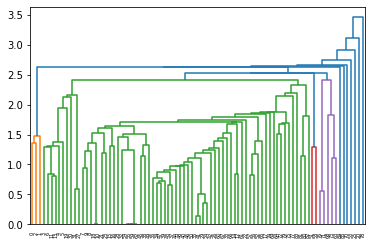

In [ ]:
plot_dendrogram(single, truncate_mode="level", p=0)
mean_sil = metrics.silhouette_score(X, labels, metric='euclidean')

**COMPLETE**: Se podrían obtener 3 clusters, 2 de tamaño similar y otro más grande

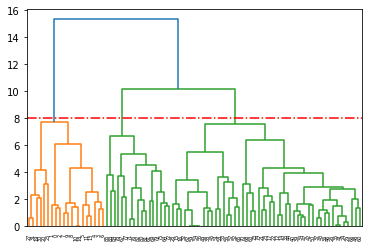

In [ ]:
plot_dendrogram(complete, truncate_mode="level", p=0)
plt.axhline(y = 8, color = 'r', linestyle = '-.')



**AVERAGE**: También parece haber 3 clusters bien formados, al igual que antes hay un cluster más grande que el resto

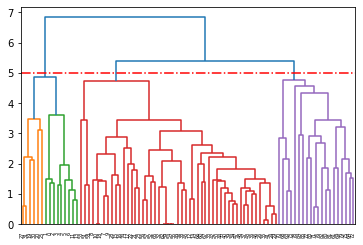

In [ ]:
plot_dendrogram(average, truncate_mode="level", p=0)
plt.axhline(y = 5, color = 'r', linestyle = '-.')


**WARD**: En este caso podríamos optar por 2 opciones distintas. La primera sería quedarnos con 4 clusters de tamaño similar (rojo), mientras que la segunda opción sería segmentar en 3 clusters habiendo uno notablemente más grande (verde)

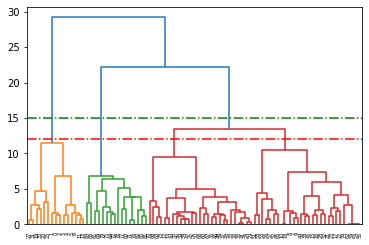

In [ ]:
plot_dendrogram(ward, truncate_mode="level", p=0)
plt.axhline(y = 12, color = 'r', linestyle = '-.')
plt.axhline(y = 15, color = 'g', linestyle = '-.')

A partir de estos dendogramas creemos que K=3 parece un buen número de clusters para nuestros datos. De entre los modelos anteriores, el que segmenta más claramente los datos en 3 clusters sería usando linkage='average'

Procedemos ahora a usar distintas métricas. Previamente estábamos usando la euclídea. Por lo que nos quedaría explorar las métricas: l1, l2, manhattan y cosine. 

Experimentando con estas métricas vimos que la métrica l2 lleva al mismo dendograma que usando la euclídea, y lo mismo ocurre entre las métricas l1 y manhattan. La cosine devuelve dendogramas poco acertados para nuestro dataset.

Esta vez no evaluaremos de nuevo con linkage='ward' puesto que necesariamente este requiere de una métrica euclídea.

Puesto que l2 lleva a lo mismo que euclidean y manhattan y l1 llevan al mismo resultado, tan solo mostraremos los dendogramas usando la métrica manhattan

In [ ]:

single2 = AgglomerativeClustering(linkage='single', affinity='manhattan', compute_distances=True)
ys2 = single2.fit(X)
complete2 = AgglomerativeClustering(linkage='complete', affinity='manhattan', compute_distances=True)
yc2 = complete2.fit(X)
average2 = AgglomerativeClustering(linkage='average', affinity='manhattan', compute_distances=True)
ya2 = average2.fit(X)


**SINGLE**: Al igual que antes no hay clusters claramente definidos. Definitivamente con linkage single no obtenemos buenos resultados

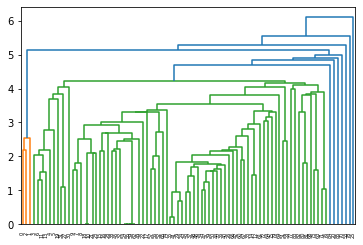

In [ ]:
plot_dendrogram(single2, truncate_mode="level", p=0)



**Complete**: Podemos ver 2 grandes clusters de tamaño muy similar

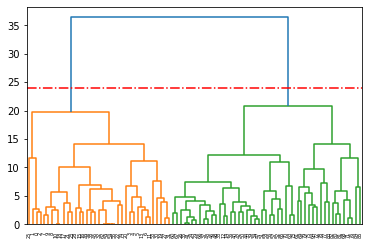

In [ ]:
plot_dendrogram(complete2, truncate_mode="level", p=0)
plt.axhline(y = 24, color = 'r', linestyle = '-.')

**AVERAGE**: Se podría dividir en 3 clusters, de tamaños muy distintos, teniendo un cluster con tan solo 3 muestras. No parece la opción más acertada

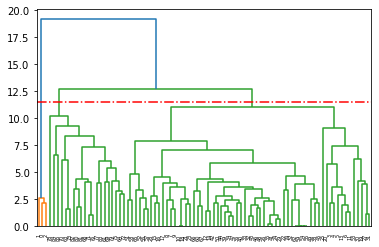

In [ ]:
plot_dendrogram(average2, truncate_mode="level", p=0)
plt.axhline(y = 11.5, color = 'r', linestyle = '-.')

### **EVALUACIÓN MODELOS**

Tras haber probado con todos los linkages y métricas creemos que para nuestro conjunto de datos la opción más adecuada sería aquella con 3 clusters pues es lo que observamos en la mayoría de dendogramas representativos. Basándonos en los dendogramas la opción más adecuada nos parece aquella con linkage='average' con una métrica euclídea puesto que se pueden observar 3 clusters claramente definidos a la misma altura y de dimensiones relativamente similares.

Vamos a evaluar con el coeficiente de Silhouette cual sería la opción más adecuada de entre:
*   Complete - euclidean (K=3)
*   Average - euclidean (K=3)
*   Ward - euclidean (K=3, K=4)
*   Complete - manhattan (K=3)





**Complete - euclidean (K=3)**


In [ ]:
complete = AgglomerativeClustering(n_clusters=3, linkage='complete', compute_distances=True)
yc = complete.fit(X)
labels = yc.labels_
metrics.silhouette_score(X, labels, metric='euclidean')


0.3039990502317843

**Average - euclidean (K=3)**

In [ ]:
average = AgglomerativeClustering(n_clusters=3, linkage='average', compute_distances=True)
ya = average.fit(X)
labels = ya.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.33284456696000736

**Ward - euclidean (K=3)**

In [ ]:
ward = AgglomerativeClustering(n_clusters=3, linkage='ward', compute_distances=True)
yw = ward.fit(X)
labels = yw.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.3275755614204932

**Ward - euclidean (K=4)**

In [ ]:
ward = AgglomerativeClustering(n_clusters=4, linkage='ward', compute_distances=True)
yw = ward.fit(X)
labels = yw.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.24372253214398754

**Complete - manhattan (K=3)**

In [ ]:
complete2 = AgglomerativeClustering(n_clusters=3, linkage='complete', affinity='manhattan', compute_distances=True)
yc2 = complete2.fit(X)
labels = yc2.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.23591444031260464

De entre las distintas opciones evaluadas la que obtiene el coeficiente de Silhouette más alto es con linkage='average' y una métrica euclídea (0.35 aprox), corroborando nuestra hipótesis inicial, por tanto, sería esta nuestra opción elegida para llevar a cabo el clustering de nuestro dataset mediante un clustering jerárquico.

## **Partitional clustering**

Hacemos uso del algoritmo KMeans para dividir los datos en distintos clusters. Para ello, evaluamos cauál es el número de clusters óptimo mediante la evaluación de la métrica de disimilaridad (hallando codo de Jambú) apoyándonos en el coeficiente de Silhouette.

El codo de Jambú indica que K=3 sería lo mas conveniente puesto que a partir de entonces no hay una gran disminución en la disimilaritud. El coeficiente de Silhouette es ligeramente mayor con K=2 que con K=3, por lo que concluimos que K=3 es lo más adecuado puesto que la pequeña disminución en este coeficiente también va acompañada de una gran disminución en la disimilaridad

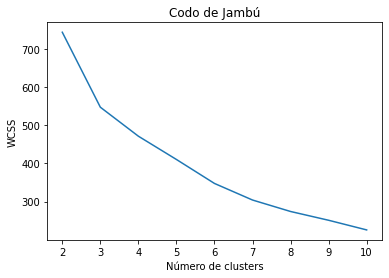

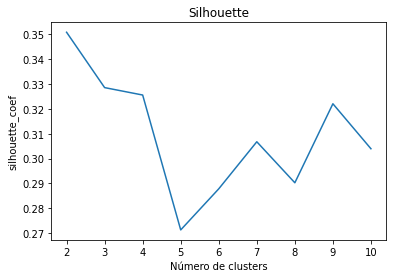

In [ ]:
wcss = []
silhouette = []
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(X)  # Aplico KMeans a la bd
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette.append(metrics.silhouette_score(X, labels, metric='euclidean'))

# Visualizamos el resultado en un plot
plt.figure(0)
plt.plot(range(2,11), wcss)
plt.title('Codo de Jambú')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

plt.figure(1)
plt.plot(range(2,11), silhouette)
plt.title('Silhouette')
plt.xlabel('Número de clusters')
plt.ylabel('silhouette_coef')
plt.show()

Tras haber concluido que tendremos 3 clusters aplicamos el algoritmo KMeans y establecemos que el algoritmo se ejecute 20 veces con distintos centroides iniciales para tratar de lograr un mejor resultado.

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=20)
y_predicted = kmeans.fit_predict(X)
X['Cluster'] = y_predicted
X

,ML,LA,OR,BD,ST,PR,Cluster
0,7.7,8.2,6.000000,6.7,8.1,9.0,0
1,6.3,7.8,6.442932,7.0,8.1,9.0,0
2,7.5,7.3,7.000000,6.6,8.1,9.0,0
3,5.5,7.2,6.000000,7.0,6.8,7.0,0
4,6.3,6.3,6.000000,7.0,6.3,7.0,0
...,...,...,...,...,...,...,...
81,1.5,3.8,3.000000,2.8,1.7,1.0,2
82,0.5,3.0,4.000000,3.6,1.8,1.0,2
83,1.2,3.0,3.000000,3.5,2.1,3.0,2
84,0.5,2.6,1.000000,2.0,2.0,3.0,2


Representamos en un scatter plot los distintos clusters en 2 dimensiones (ML, ST), aún así no podemos sacar conclusiones sobre cómo se han generado los clusters puesto que no podemos visualizarlo en n-dimensiones.

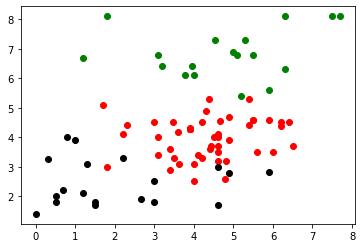

In [ ]:
X0 = X[X.Cluster==0]
X1 = X[X.Cluster==1]
X2 = X[X.Cluster==2]

plt.scatter(X0.ML, X0.ST, color='green')
plt.scatter(X1.ML, X1.ST, color='red')
plt.scatter(X2.ML, X2.ST, color='black')

Evaluamos el modelo mediante el coeficiente de Silhouette y nos da un resultado relativamente bajo (0.3 aprox). Esto no tiene por qué significar que el modelo sea incorrecto, puede ser tan solo que los clusters se encuentren muy cerca los unos de los otros.

In [ ]:
labels = kmeans.labels_
mean_sil = metrics.silhouette_score(X, labels, metric='euclidean')
point_sil = metrics.silhouette_samples(X, labels, metric='euclidean')

print(mean_sil) 
print(point_sil)

0.3432894993891437
[ 0.39248699  0.44655308  0.41878874  0.4159345   0.37528311  0.44855207
  0.4286874   0.00613741  0.13944012 -0.06190477  0.26293197  0.42488099
  0.4618635   0.43707342  0.49861013  0.25147216  0.28809957  0.2563654
  0.26293222  0.25585886  0.2224335   0.32786248  0.3125037   0.38231853
  0.51392219  0.33602988  0.49241498  0.20745285  0.39589209  0.52128811
  0.16144743  0.21979671  0.47398932  0.43890053  0.51144658  0.54578958
  0.53436536  0.42541273  0.37537658  0.50785929  0.45106341  0.55021586
  0.43567473  0.47783025  0.48180235  0.36963543  0.46322026  0.47364134
  0.40832869  0.2979385   0.34675493  0.26704926  0.34906008 -0.02997355
  0.55657075  0.55657075  0.40583154  0.37425385  0.27447546  0.55657075
  0.26945019  0.13285778  0.55657075  0.02896622  0.19478494  0.1816176
  0.26516627  0.1687704   0.21416896  0.10995498  0.09267951  0.27597152
  0.21097631  0.15187989  0.36360249  0.28341204  0.26165029  0.2565731
  0.219785    0.34328624  0.4598796

# **CONCLUSIÓN**

A modo de conclusión, y en base a lo observado previamente podriamos intuir que el dataset contiene 3 clusters correspondientes a alumnos con notas bajas, con notas altas, y alumnos con nota medias, por ello la existencia de un cluster mayor que el resto (la mayoría de muestras están alrededor de la media). Aún así esto tan solo sería una mera hipótesis. 

En cuanto a algoritmos de clustering, ambos concluyen que 3 sería el número de clusters más adecuado y ambos obtienen un coeficiente de Silhouette muy similar, posiblemente ambos algoritmos hagan clusterings similares.